#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

from razdel import tokenize as razdel_tokenize
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [2]:
# открываем датасет. я взяла меньше данных, тк иначе у меня зависало
wiki = open('wiki_data.txt').read().split('\n')[:10000]

In [3]:
# лемматизация
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return normalized_text
# возвращает из строки список с первоначальными формами слов

In [4]:
# считаем количество упоминаний, чтобы отсеять самые редкие
vocab = Counter()
for text in wiki:
    vocab.update(normalize(text))
vocab
# Возьмем только те, что встретились больше 30 раз
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [5]:
# Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре).
# Создадим для этого специальный словарь с индексами.
# В этот словарь нам нужно положить дополнительный токен - PAD
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
# {'PAD': 0, 'хвост': 1, 'кота': 2}

id2word = {i:word for word, i in word2id.items()}
#     получается словарь {0: 'PAD', 1: 'хвост', 2: 'кота'}

In [6]:
# Заменяем слова на индексы в датасете
sentences = [] # это будет список списков индексов

for text in wiki:
    tokens = normalize(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [7]:
# проверяем что список списков равен по длине изначальному датасету
len(sentences)

10000

In [8]:
# и что там содержатся индексы слов
sentences[0][0]

613

In [9]:
# считаем размер получившегося словаря с индексами
vocab_size = len(id2word)
vocab_size

7674

In [10]:
# тут мы считаем, сколько раз какой индекс встретился в датасете
vocab_ids = Counter()
for sent in sentences:
        vocab_ids.update(sent)
vocab_ids.most_common()

[(4692, 131662),
 (1767, 69216),
 (384, 46227),
 (2623, 40086),
 (1149, 33995),
 (1293, 32353),
 (4639, 29952),
 (5503, 29944),
 (4764, 28154),
 (5814, 18218),
 (6479, 18141),
 (6300, 12715),
 (4731, 11907),
 (4253, 11029),
 (5352, 10404),
 (3481, 9986),
 (3021, 9641),
 (1659, 8877),
 (2118, 8599),
 (5062, 8100),
 (2780, 8024),
 (3829, 7505),
 (3246, 7173),
 (6118, 7142),
 (4680, 6459),
 (5243, 6404),
 (850, 6281),
 (7550, 6175),
 (7446, 6097),
 (198, 6045),
 (6168, 6017),
 (3305, 5983),
 (928, 5872),
 (1595, 5823),
 (3061, 5595),
 (702, 5184),
 (5153, 4980),
 (570, 4923),
 (5229, 4895),
 (6128, 4716),
 (2912, 4385),
 (630, 4193),
 (2718, 4066),
 (3748, 4027),
 (3857, 3881),
 (1093, 3863),
 (5522, 3796),
 (2131, 3618),
 (1960, 3589),
 (4054, 3589),
 (6480, 3552),
 (7169, 3547),
 (7492, 3546),
 (43, 3357),
 (4292, 3337),
 (5369, 3270),
 (5598, 3265),
 (1729, 3149),
 (3416, 3121),
 (475, 3103),
 (4433, 3083),
 (6153, 2933),
 (78, 2817),
 (4664, 2757),
 (6654, 2722),
 (3538, 2720),
 (3926

In [11]:
# присваиваю индексам слов вероятности, обратные частотности
probas_vocab_ids_counter = Counter({word:1-(c/sum(vocab_ids.values())) for word, c in vocab_ids.items()})
probas_vocab_ids_counter[242]

0.9997621110456123

In [12]:
# создаю отдельный список вероятностей для передачи в модель
probas_vocab_ids_list = []
for i in range(vocab_size):
    probas_vocab_ids_list.append(probas_vocab_ids_counter[i])
probas_vocab_ids_list[:3]

[0, 0.9998867648577114, 0.9999281575357749]

In [13]:
p = np.array(probas_vocab_ids_list)
p /= p.sum()
p
# нормализовала вероятности чтобы сумма была = 1

array([0.        , 0.00013033, 0.00013033, ..., 0.00013034, 0.00013034,
       0.00013031])

In [14]:
# skip gram

def gen_batches_sg(sentences, window = 6, batch_size=1000): # общее окно = 12
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.choice(np.array(vocab_size), p = p))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [15]:
# cbow 
def gen_batches_cbow(sentences, window = 3, batch_size=1000): # общее окно = 6
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.choice(np.array(vocab_size), p = p))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [16]:
# skip gram

inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_sg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_sg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_sg.fit(gen_batches_sg(sentences[:9000], window=6),
          validation_data=gen_batches_sg(sentences[1000:],  window=6),
          batch_size=1000, # количество пар слов в 1 баче обучающей выборки
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=5)

2022-01-31 23:31:15.932291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
5000/5000 [==============================] - 657s 131ms/step - loss: 0.4762 - accuracy: 0.7771 - val_loss: 0.3868 - val_accuracy: 0.8254
Epoch 2/5
5000/5000 [==============================] - 700s 140ms/step - loss: 0.4501 - accuracy: 0.7981 - val_loss: 0.3804 - val_accuracy: 0.8353
Epoch 3/5
5000/5000 [==============================] - 681s 136ms/step - loss: 0.4368 - accuracy: 0.8055 - val_loss: 0.4085 - val_accuracy: 0.8179
Epoch 4/5
5000/5000 [==============================] - 655s 131ms/step - loss: 0.4439 - accuracy: 0.8017 - val_loss: 0.4486 - val_accuracy: 0.7960
Epoch 5/5
5000/5000 [==============================] - 658s 132ms/step - loss: 0.4303 - accuracy: 0.8080 - val_loss: 0.3903 - val_accuracy: 0.8283


In [19]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [23]:
embeddings_sg = model_sg.layers[2].get_weights()[0]
most_similar('кавказ', embeddings_sg)

['кавказ',
 'дагестан',
 'северный',
 'кавказский',
 'турция',
 'черноморский',
 'африка',
 'монголия',
 'союзный',
 'восточный']

In [24]:
most_similar('бассейн', embeddings_sg)

['бассейн',
 'приток',
 'плато',
 'подножие',
 'возвышенность',
 'юго-восток',
 'озеро',
 'пересекать',
 'впадать',
 'исток']

In [25]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_cb = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cb.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cb.fit(gen_batches_cbow(sentences[:9000], window=3),
          validation_data=gen_batches_cbow(sentences[1000:],  window=3),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
2000/2000 [==============================] - 298s 148ms/step - loss: 0.4271 - accuracy: 0.8082 - val_loss: 0.3337 - val_accuracy: 0.8534
Epoch 2/2
2000/2000 [==============================] - 290s 145ms/step - loss: 0.3368 - accuracy: 0.8564 - val_loss: 0.3156 - val_accuracy: 0.8644


In [26]:
embeddings_cb = model_cb.layers[2].get_weights()[0]
most_similar('кавказ', embeddings_cb)

['кавказ',
 'алтай',
 'окраина',
 'равнина',
 'полуостров',
 'сопка',
 'побережье',
 'юго-восток',
 'склон',
 'восток']

In [27]:
most_similar('бассейн', embeddings_cb)

['бассейн',
 'впадать',
 'устье',
 'впадение',
 'тетерев',
 'скалистый',
 'русло',
 'верховье',
 'ледник',
 'оконечность']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [28]:
import gensim

In [ ]:
# берем тот же датасет
wiki = open('wiki_data.txt').read().split('\n')[:10000]

In [ ]:
# лемматизация
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return normalized_text

In [29]:
# составляем список списков из изначальных форм слов
texts = []

for text in wiki:
    texts.append(normalize(text))
texts

[['новостройка',
  'нижегородский',
  'область',
  'новостро́йка',
  '—',
  'сельский',
  'посёлок',
  'в',
  'дивеевский',
  'район',
  'нижегородский',
  'область',
  'входить',
  'в',
  'состав',
  'сатисский',
  'сельсовет',
  'посёлок',
  'расположить',
  'в',
  '12,5',
  'км',
  'к',
  'юг',
  'от',
  'село',
  'дивеево',
  'и',
  '1',
  'км',
  'к',
  'запад',
  'от',
  'город',
  'саров',
  'на',
  'право',
  'берег',
  'река',
  'вичкинза',
  'правый',
  'приток',
  'река',
  'сатис',
  'окружить',
  'смешанный',
  'лес',
  'соединить',
  'асфальтовый',
  'дорога',
  'с',
  'посёлок',
  'цыгановка',
  '1,5',
  'км',
  'и',
  'грунтовый',
  'просёлочный',
  'дорога',
  'с',
  'посёлок',
  'сатис',
  '3,5',
  'км',
  'название',
  'новостройка',
  'являться',
  'сугубо',
  'официальный',
  'местный',
  'население',
  'использовать',
  'исключительно',
  'альтернативный',
  'название',
  '—',
  'хитрый',
  'употребляться',
  'языковой',
  'оборот',
  '«',
  '…',
  'на',
  'хитрый

In [ ]:
# word2vec:

In [ ]:
# с параметрами по умолчанию:

In [30]:
%%time
w2v_basic = gensim.models.Word2Vec(texts)

CPU times: user 43.1 s, sys: 935 ms, total: 44 s
Wall time: 19.8 s


In [32]:
w2v_basic.wv.most_similar('кавказ')

[('полуостров', 0.8556957244873047),
 ('восток', 0.8540028929710388),
 ('побережье', 0.8522852659225464),
 ('юг', 0.8327992558479309),
 ('восточный', 0.8300058245658875),
 ('окраина', 0.8280153870582581),
 ('южный', 0.8222750425338745),
 ('юго-западный', 0.8203734755516052),
 ('черноморский', 0.8202522397041321),
 ('север', 0.8155315518379211)]

In [ ]:
# меняем параметры, используем cbow:

In [33]:
%%time
w2v_custom1 = gensim.models.Word2Vec(texts, 
                             vector_size=500, # устанавливаем размер вектора (обычно от 100 до 1000)
                             min_count=20, # убираем все слова, которые встр меньше 20 раз
                             max_vocab_size=90000, # максимальный размер словаря
                             hs = 1,
                             cbow_mean=0, # у нас по умолч.sg=0, т.е. исп.cbow
                             window=3, # возьмем такое же как в задании 1
                             epochs=2) # взяла немного тк у меня очень медленно работает ноутбук

CPU times: user 1min 8s, sys: 507 ms, total: 1min 9s
Wall time: 27.7 s


In [34]:
w2v_custom1.wv.most_similar('кавказ')

[('африка', 0.7781168222427368),
 ('македония', 0.764032781124115),
 ('побережье', 0.7439340949058533),
 ('осетия', 0.7427651882171631),
 ('сибирь', 0.740425169467926),
 ('аляска', 0.7397738099098206),
 ('восточный', 0.738270103931427),
 ('полуостров', 0.7377567291259766),
 ('америка', 0.7325184345245361),
 ('индия', 0.7300042510032654)]

In [ ]:
# меняем параметры, используем sg:

In [35]:
%%time
w2v_custom2 = gensim.models.Word2Vec(texts, 
                             vector_size=500, # устанавливаем размер вектора (обычно от 100 до 1000)
                             min_count=20, # убираем все слова, которые встр меньше 20 раз
                             max_vocab_size=90000, # максимальный размер словаря
                             sg=1, # здесь используем skip-gram
                             sample=1e-5, # поэтому имеет смысл использовать sample, чтобы ускорить работу модели
                             window=6, # возьмем такое же как в задании 1
                             ns_exponent=0.80, # штраф 0.8 
                             epochs=2) # взяла немного тк у меня очень медленно работает ноутбук

CPU times: user 49.5 s, sys: 797 ms, total: 50.3 s
Wall time: 20 s


In [44]:
w2v_custom2.wv.most_similar('кавказ')

[('болото', 0.9992571473121643),
 ('побережье', 0.9991686344146729),
 ('отделить', 0.999167263507843),
 ('окрестность', 0.9991305470466614),
 ('озёрный', 0.999123215675354),
 ('зона', 0.9991127848625183),
 ('песчаный', 0.9990994930267334),
 ('сесть', 0.9990745186805725),
 ('правый', 0.9990711808204651),
 ('гряда', 0.999068558216095)]

In [45]:
# интересно, что на некоторые слова модель выдает синонимы (церковь, здание, приход) , а на другие - как будто "слова по теме"
# (как с кавказом)
w2v_custom2.wv.most_similar('церковь')

[('епархия', 0.9984411001205444),
 ('здание', 0.9981904625892639),
 ('согласно', 0.9979889392852783),
 ('княжество', 0.9979586601257324),
 ('пермский', 0.9976039528846741),
 ('семья', 0.9975534677505493),
 ('соседний', 0.9975284934043884),
 ('вологодский', 0.997483491897583),
 ('приход', 0.997481107711792),
 ('усадьба', 0.997431755065918)]

In [ ]:
# fasttext:

In [ ]:
!pip install FastText

In [38]:
%%time
ft_basic = gensim.models.FastText(texts)
# с параметрами по умолчанию

CPU times: user 4min 13s, sys: 5.53 s, total: 4min 19s
Wall time: 1min 46s


In [39]:
ft_basic.wv.most_similar('кавказ')

[('закавказье', 0.8335808515548706),
 ('киргизия', 0.8331384062767029),
 ('ревизия', 0.8295009136199951),
 ('дунай', 0.8217880725860596),
 ('грузия', 0.8086681962013245),
 ('владикавказ', 0.8019154071807861),
 ('казахстан', 0.7998363971710205),
 ('бай', 0.7952122688293457),
 ('североморск', 0.7899685502052307),
 ('карелия', 0.7890680432319641)]

In [46]:
ft_basic.wv.most_similar('церковь')

[('монастырь', 0.9112663269042969),
 ('храм', 0.8930495381355286),
 ('собор', 0.8878259658813477),
 ('святилище', 0.8465439677238464),
 ('святск', 0.8456452488899231),
 ('святыня', 0.8310517072677612),
 ('хрущ', 0.82157301902771),
 ('архиерей', 0.8100411295890808),
 ('монах', 0.8057267069816589),
 ('часовня', 0.7976295948028564)]

In [40]:
%%time
ft_custom1 = gensim.models.FastText(texts, min_n=4, max_n=5)
# с параментами заданными вручную
# минимальная длина для символьных нграмм возьмем 4 и посмотрим, насколько хуже будет результат

CPU times: user 2min 25s, sys: 3.36 s, total: 2min 28s
Wall time: 1min 2s


In [41]:
ft_custom1.wv.most_similar('кавказ')

[('закавказье', 0.9341717958450317),
 ('владивосток', 0.8478277325630188),
 ('амнезия', 0.8344642519950867),
 ('востоковед', 0.8310105800628662),
 ('зарубежье', 0.8297522664070129),
 ('киргизия', 0.8230956196784973),
 ('правобережье', 0.8225356340408325),
 ('восток-запад', 0.8180882930755615),
 ('североморск', 0.8163484930992126),
 ('восток', 0.8103973865509033)]

In [47]:
ft_custom1.wv.most_similar('церковь')

[('монастырь', 0.9078184962272644),
 ('собор', 0.9042356610298157),
 ('храм', 0.9014189839363098),
 ('берсерков', 0.9005288481712341),
 ('штырь', 0.8832648992538452),
 ('церн', 0.8797866702079773),
 ('перковы', 0.8460618257522583),
 ('святилище', 0.8438047766685486),
 ('святыня', 0.8416526913642883),
 ('святск', 0.8383317589759827)]

In [42]:
%%time
ft_custom2 = gensim.models.FastText(texts, min_n=5, max_n=4)
# посмотрим на результат без использования символьных n-грамм (ставим max меньше min)

CPU times: user 41.7 s, sys: 514 ms, total: 42.2 s
Wall time: 17.5 s


In [43]:
ft_custom2.wv.most_similar('кавказ')

[('полуостров', 0.857414960861206),
 ('побережье', 0.8419532775878906),
 ('восток', 0.8309528827667236),
 ('восточный', 0.8210015296936035),
 ('юг', 0.8059089183807373),
 ('север', 0.8022730946540833),
 ('сибирь', 0.8022340536117554),
 ('южный', 0.7977592349052429),
 ('юго-западный', 0.7939429879188538),
 ('юго-запад', 0.7914349436759949)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [ ]:
# у меня не получилось понять, как сделать проверку моделей из задания 1 и предобученной модели с rus-vectores.
# Поэтому я проверяла только модели из задания 2.

In [49]:
data = pd.read_csv('labeled.csv')

In [50]:
data['norm_text'] = data.comment.apply(normalize)

In [51]:
data

comment  toxic  \
0                   Верблюдов-то за что? Дебилы, бл...\n    1.0   
1      Хохлы, это отдушина затюканого россиянина, мол...    1.0   
2                              Собаке - собачья смерть\n    1.0   
3      Страницу обнови, дебил. Это тоже не оскорблени...    1.0   
4      тебя не убедил 6-страничный пдф в том, что Скр...    1.0   
...                                                  ...    ...   
14407  Вонючий совковый скот прибежал и ноет. А вот и...    1.0   
14408  А кого любить? Гоблина тупорылого что-ли? Или ...    1.0   
14409  Посмотрел Утомленных солнцем 2. И оказалось, ч...    0.0   
14410  КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...    1.0   
14411  До сих пор пересматриваю его видео. Орамбо кст...    0.0   

                                               norm_text  
0                       [верблюд-то, за, что, дебил, бл]  
1      [хохол, это, отдушина, затюканый, россиянин, м...  
2                              [собака, собачий, смерть]  
3      [страница, обновить, дебил, это, тоже, не, оск...  
4      [ты, не, убедить, 6-страничный, пдф, в, тот, ч...  
...                                                  ...  
14407  [вонючий, совковый, скот, прибежать, и, ныть, ...  
14408  [а, кто, любить, гоблин, тупорылый, что-ли, ил...  
14409  [посмотреть, утомлённый, солнце, 2, и, оказать...  
14410  [крымотред, нарушать, правило, раздел, так, к,...  
14411  [до, сей, пора, пересматривать, он, видео, ора...  

[14412 rows x 3 columns]

In [52]:
# собираем словарь
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6386

In [53]:
# переводим слова в индексы
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [54]:
# создаем список списков индексов из всех текстов датасета
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [55]:
# проверка что частые слова там есть
word2id['за']

5076

In [56]:
# проверка что в Х попали индексы, и мы видим что там не все лосва, а только те чья частота больше 5
# (в 1 тексте больше слов, чем в X[0])
X[0]

[5076, 2483, 150, 1547]

In [57]:
# превращаем векторы из Х в 2D Numpy array размерности X*100 с помощью паддинга
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
# инициализируем у
y = data.toxic.values

In [58]:
# делим данные на трейн и тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [59]:
# поскольку модель со встроенной векторизацией и fasttext были на семинаре, проверю модель word2vec
# accuracy на встроенной векторизации на последней эпохе была: 0.9349
# accuracy на векторизации fasttext на последней эпохе была: 0.7726

In [60]:
# обучаем word2vec, и на данных задания 2, и на данных labeled.csv:

In [62]:
%%time
w2v_for_classification = gensim.models.Word2Vec(texts + data['norm_text'].values.tolist(), window=10, epochs=10)

CPU times: user 1min 51s, sys: 1.06 s, total: 1min 52s
Wall time: 46.2 s


In [63]:
# делаем матрицу с векторами из Word2Vec
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v_for_classification.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то рандомный вектор
        continue
        weights[i] = w2v_for_classification.wv['фывапролджэ']

In [64]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_w2v_classification = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_w2v_classification.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
# обучаем модель
model_w2v_classification.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6004 - accuracy: 0.6649 - val_loss: 0.5468 - val_accuracy: 0.7101
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7007 - val_loss: 0.5111 - val_accuracy: 0.7573
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5189 - accuracy: 0.7363 - val_loss: 0.4885 - val_accuracy: 0.7767
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.4991 - accuracy: 0.7588 - val_loss: 0.4740 - val_accuracy: 0.7795
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.4850 - accuracy: 0.7763 - val_loss: 0.4606 - val_accuracy: 0.7933
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.4742 - accuracy: 0.7838 - val_loss: 0.4513 - val_accuracy: 0.7920
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.4658 - accuracy: 0.7896 - val_loss: 0.4461 - val_accuracy: 0.8044
Epoch 

In [66]:
# результат - accuracy 0.8224 на последней эпохе. 
# Качество получилось хуже, чем у модели со встроенными эмбедингами с семинара (0.9349),
# но лучше, чем у модели с fasttext (0.7726)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


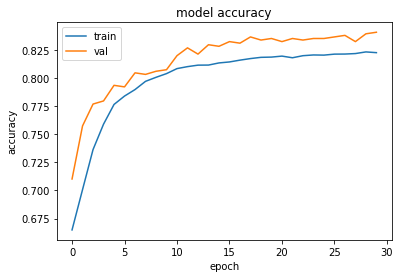

In [67]:
print(model_w2v_classification.history.history.keys())
# summarize history for accuracy
plt.plot(model_w2v_classification.history.history['accuracy'])
plt.plot(model_w2v_classification.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()